In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import tensorflow as tf
import pathlib
import ipywidgets as widgets
import io

from IPython.display import Javascript
from PIL import Image
from ipywidgets import interact
from PIL import ImageShow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download Dataset

In [2]:
dataset_path = "../input/bee-images-separated/bee_imgs"
data_dir = pathlib.Path(dataset_path)

# Create Dataset
Validation split splits the images into 80% for training and 20% for validation

In [3]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names

Found 5172 files belonging to 6 classes.
Using 4138 files for training.
Found 5172 files belonging to 6 classes.
Using 1034 files for validation.


# Configure Dataset
dataset.cache(): keeps images in memory after they're loaded off the disk for the first epoch
<br>dataset.prefetch(): overlaps data preprocessing and model execution while training

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize Dataset

In [5]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.5977605


# Create Model
Consists of three convolutional blocks with each having a max pooling layers
<br>The fully connected layer is activated by the ReLU function

In [6]:
num_classes = 6

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile Data
Use Adam optimizer and the Sparse Categorical Croessentropy loss function

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train Model

In [8]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
130/130 [==============================] - 85s 653ms/step - loss: 0.8108 - accuracy: 0.7209 - val_loss: 0.5054 - val_accuracy: 0.8066
Epoch 2/10
130/130 [==============================] - 75s 581ms/step - loss: 0.3532 - accuracy: 0.8589 - val_loss: 0.3478 - val_accuracy: 0.8878
Epoch 3/10
130/130 [==============================] - 78s 598ms/step - loss: 0.2429 - accuracy: 0.8975 - val_loss: 0.2957 - val_accuracy: 0.8694
Epoch 4/10
130/130 [==============================] - 76s 581ms/step - loss: 0.1897 - accuracy: 0.9212 - val_loss: 0.4064 - val_accuracy: 0.8491
Epoch 5/10
130/130 [==============================] - 76s 587ms/step - loss: 0.1691 - accuracy: 0.9321 - val_loss: 0.2516 - val_accuracy: 0.9023
Epoch 6/10
130/130 [==============================] - 75s 580ms/step - loss: 0.1199 - accuracy: 0.9490 - val_loss: 0.2041 - val_accuracy: 0.9178
Epoch 7/10
130/130 [==============================] - 76s 588ms/step - loss: 0.0913 - accuracy: 0.9633 - val_loss: 0.2317 - val_ac

# Predict on New data

Upload a new image to be analyzed

In [9]:
uploader = widgets.FileUpload(
    accept='.png, .jpg',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(uploader)

FileUpload(value={}, accept='.png, .jpg', description='Upload')

In [10]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Analyze Next Image")
button.on_click(run_all)
display(button)

Button(description='Analyze Next Image', style=ButtonStyle())

After the image has been uploaded, save it to output directory and display image back to user

In [11]:
img_name=""
#save the uploaded image to a folder
for name, file_info in uploader.value.items():
    img = Image.open(io.BytesIO(file_info['content']))
    img_name = name
    with open(name, 'wb') as fp:
        fp.write(file_info['content'])

    bee_img = './' + img_name

#display chosen image back to user
#PIL.Image.open(bee_img)

Display Prediction

This image most likely belongs to the category ants with a 99.69 percent confidence.


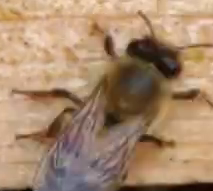

In [12]:
if img_name == "":
    bee_img = "../input/bee-images-separated/bee_imgs/ants/013_008.png"
    
img = keras.preprocessing.image.load_img(
    bee_img, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to the category {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(bee_img)